## Tutorial - Training of Voronoy models

This tutorial demonstrates how to train image classification models and (easily created) toy-dataset Voronoy dataset (that can be used to showcase the library's functionality).



In [ ]:
# Mount Google Drive. #remove
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install packages. #remove
!pip install captum opencv-python torch torchvision
#!pip install captum opencv-python torch==1.8.0 torchvision==0.9.0
#!pip install captum opencv-python torch torchvision #torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install captum opencv-python torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# Imports general.
import sys
import warnings
import gc
import cv2
import glob
import pathlib
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import captum
from torchvision import transforms
from tqdm import tqdm
from captum.attr import *
import random

# Import package.
sys.path.append('/content/drive/MyDrive/Projects/xai_quantification_toolbox')
import quantus

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

Mounted at /content/drive
     |████████████████████████████████| 1.4 MB 8.5 MB/s 


### Load Voronoy dataset.


In [ ]:
!ls /content/drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/data/

test_labels_voronoy  train_labels_voronoy


In [ ]:
path_data = "/content/drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/data/"
class_labels = {0: "Green", 1: "Pink", 2: "Orange"}
augmentations = True

if pathlib.Path(path_data + "train_images_voronoy").is_file():
    
    train_images = torch.load(path_data + "train_images_voronoy")
    test_images = torch.load(path_data + "test_images_voronoy")
    train_labels = torch.load(path_data + "train_labels_voronoy")
    test_labels = torch.load(path_data + "test_labels_voronoy")
    train_masks = torch.load(path_data + "train_masks_voronoy")
    test_masks = torch.load(path_data + "test_masks_voronoy")

else:

    # Configs.
    path = '/content/drive/MyDrive/Projects/data/voronoy/'
    nr_channels = 3
    img_size = 224

    # Read png images and labels from txt file.
    augmentations =  transforms.Compose([transforms.ToTensor(), # No affine, flips, rotations = destroy gt mask.
                                         transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
    
    ds = torchvision.datasets.ImageFolder(root=path, transform=augmentations)
    labels = [l[1] for l in np.loadtxt(path+"ds/labels.txt", delimiter=" ", skiprows=0)]

    # Torchify.
    labels = torch.LongTensor(labels)
    images = torch.zeros(len(ds)//2, nr_channels, img_size, img_size)
    masks = torch.zeros(len(ds)//2, nr_channels, img_size, img_size)

    # Extract masks and images from the full dataset.
    for ix, (img_augmented, mask) in enumerate(zip(torch.utils.data.Subset(ds, np.arange(0, len(ds), 2)), torch.utils.data.Subset(ds, np.arange(0, len(ds), 1)[1::2]))):
        images[ix] = img_augmented[0]
        masks[ix] = mask[0]

    # Split into training and test sets.
    train_images = images[:int(len(images)*0.8)]
    train_masks = masks[:int(len(images)*0.8)]
    train_labels = labels[:int(len(images)*0.8)]
    test_images = images[int(len(images)*0.8):]
    test_masks = masks[int(len(images)*0.8):]
    test_labels = labels[int(len(images)*0.8):]

    # Save torch tensors.
    torch.save(train_images, path_data + "train_images_voronoy")
    torch.save(train_masks, path_data + "train_masks_voronoy"), 
    torch.save(train_labels,  path_data + "train_labels_voronoy")
    torch.save(test_images, path_data + "test_images_voronoy")
    torch.save(test_masks, path_data + "test_masks_voronoy"), 
    torch.save(test_labels,  path_data + "test_labels_voronoy")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


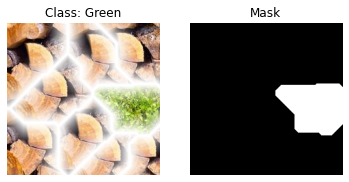

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


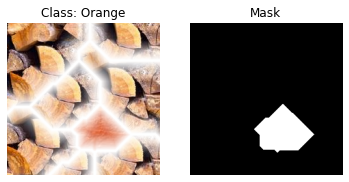

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


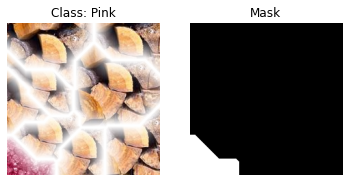

In [ ]:
def plot_example(index):
    """Plot image and corresponding mask."""
    plt.subplot(1, 2, 1)
    plt.imshow(np.moveaxis(quantus.denormalize_image(test_images[index].numpy()), 0, -1))
    plt.title(f"Class: {class_labels[test_labels[index].item()]}")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(np.moveaxis(test_masks[index].numpy(), 0, -1))
    plt.title(f"Mask")
    plt.axis("off")
    plt.show()

# Plot!
[plot_example(index=i) for i in [0, 20, 16]];

### Train image classification models.
 

In [ ]:
def train_model(model, 
                images: torchvision.datasets, 
                labels: torchvision.datasets,
                device: torch.device, 
                criterion: torch.nn, 
                optimizer: torch.optim,
                epochs: int = 20, 
                batch_size: int = 50,
                acc_criteria: float = 0.99,
                evaluate: bool = True,
                plot: bool = True):
    """Train torch model."""
    
    model.to(device)
    criterion.to(device)
    
    test_acc = 0.01
    batches = np.arange(0, len(images), batch_size)
    train_batches = batches[:int(len(batches)*0.8)]
    val_batches = batches[int(len(batches)*0.8):]

    train_accs = []
    val_accs = []

    for epoch in range(epochs):

        if test_acc >= acc_criteria:
                break

        for b in train_batches:

            model.train()

            x_batch, y_batch = images[b:b+batch_size].to(device), labels[b:b+batch_size].to(device)
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        '''
        # Evaluate model!
        if evaluate:
            y_pred, y_true = evaluate_model(model, images, labels, val_batches, batch_size, device)
            val_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
            print(f"Epoch {epoch+1}/{epochs} - val accuracy: {(100 * val_acc):.2f}%")

            y_pred, y_true = evaluate_model(model, x_batch, y_batch, device)
            train_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())

            train_accs.append(train_acc)
            val_accs.append(val_acc)
        

    if plot:
        plot_learning_curves(train_accs, val_accs)
        '''

    return model

def evaluate_model(model, images, labels, val_batches, device, batch_size=50):
    
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)
    
    with torch.no_grad():
        
        for b in test_batches:
            x_batch, y_batch = images[b:b+batch_size].to(device), labels[b:b+batch_size].to(device)
            logits = torch.cat([logits, model(x_batch)])
            targets = torch.cat([targets, y_batch])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

def plot_learning_curves(train_accs: list, val_accs: list):
    """Plot developments of training and validation accuracies."""
    plt.figure(figsize=(6, 4))
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    plt.show()

#### Pre-load architectures, freeze and unfreezed weights versions.

In [ ]:
# Load architectures with pre-trained ImageNet weights.
models = {"mobilenet_freezed" : torchvision.models.mobilenet_v3_small(pretrained=True),
          #"resnet18_freezed" : torchvision.models.resnet18(pretrained=True),
          #"vgg16_freezed" : torchvision.models.vgg16(pretrained=True)
          }

# Freeze the layers.
for model_name, model in models.items():
    for param in model.parameters():
        param.requires_grad = False
        
# Update the last layer.
models["mobilenet_freezed"].classifier[3] = torch.nn.Linear(1024, 3) 
#models["vgg16_freezed"].classifier[6] = torch.nn.Linear(4096, 3)  
#models["resnet18_freezed"].fc = torch.nn.Linear(512, 3)

# Make unfreezed versions.
models["mobilenet_unfreezed"] = torchvision.models.mobilenet_v3_small(pretrained=True)
#models["resnet18_unfreezed"] = torchvision.models.resnet18(pretrained=True)
#models["vgg16_unfreezed"] = torchvision.models.vgg16(pretrained=True)

# Update the last layer.
models["mobilenet_unfreezed"].classifier[3] = torch.nn.Linear(1024, 3) 
#models["vgg16_unfreezed"].classifier[6] = torch.nn.Linear(4096, 3)  
#models["resnet18_unfreezed"].fc = torch.nn.Linear(512, 3)

In [ ]:
def load_models(name: str = "mlp"):
    """Load different torch models."""

    if "mlp28" in name:
        model = MLP28()

    elif "mlp56" in name:
        model = MLP56()
        
    elif "mlp112" in name:
        model = MLP112()
    
    elif "mlp224" in name:
        model = MLP224()

    elif "mobilenet" in name:
        model = torchvision.models.mobilenet_v3_small(pretrained=True)
        model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, 3)
    
    elif "resnet18" in name:
        model = torchvision.models.resnet18(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, 3)

    elif "vgg16" in name:        
        model = torchvision.models.vgg16(pretrained=True)
        model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 3)  
    
    path_model_weights = f"drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/model_objs/voronoy_{name}"
    model.load_state_dict(torch.load(path_model_weights))

    return model

#### Train MLPs.

In [ ]:
class MLP28(torch.nn.Module):
    """
    Simple MLP implementation-
    https://github.com/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb
    """
    def __init__(self, ins=224*224*3, outs=3):
        super().__init__()
        self.input_fc = torch.nn.Linear(ins, 28)
        self.hidden_fc = torch.nn.Linear(28, 14)
        self.output_fc = torch.nn.Linear(14, outs)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = torch.nn.functional.relu(self.input_fc(x))
        x = torch.nn.functional.relu(self.hidden_fc(x))
        x = self.output_fc(x)
        
        return x
        
class MLP56(torch.nn.Module):
    """
    Simple MLP implementation-
    https://github.com/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb
    """
    def __init__(self, ins=224*224*3, outs=3):
        super().__init__()
        self.input_fc = torch.nn.Linear(ins, 56)
        self.hidden_fc = torch.nn.Linear(56, 28)
        self.output_fc = torch.nn.Linear(28, outs)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = torch.nn.functional.relu(self.input_fc(x))
        x = torch.nn.functional.relu(self.hidden_fc(x))
        x = self.output_fc(x)
        
        return x


class MLP112(torch.nn.Module):
    """
    Simple MLP implementation-
    https://github.com/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb
    """
    def __init__(self, ins=224*224*3, outs=3):
        super().__init__()
        self.input_fc = torch.nn.Linear(ins, 112)
        self.hidden_fc = torch.nn.Linear(112, 56)
        self.output_fc = torch.nn.Linear(56, outs)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = torch.nn.functional.relu(self.input_fc(x))
        x = torch.nn.functional.relu(self.hidden_fc(x))
        x = self.output_fc(x)
        
        return x


class MLP224(torch.nn.Module):
    """
    Simple MLP implementation-
    https://github.com/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb
    """
    def __init__(self, ins=224*224*3, outs=3):
        super().__init__()
        self.input_fc = torch.nn.Linear(ins, 224)
        self.hidden_fc = torch.nn.Linear(224, 112)
        self.output_fc = torch.nn.Linear(112, outs)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = torch.nn.functional.relu(self.input_fc(x))
        x = torch.nn.functional.relu(self.hidden_fc(x))
        x = self.output_fc(x)
        
        return x


In [ ]:
# Train an MLP models.
models["mlp112"] = MLP112()

name = "mlp112"
model = models["mlp112"]
path_model_weights = f"drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/model_objs/voronoy_{name}"

# Train and evaluate model.
model = train_model(model=model.to(device),
                    images=train_images.to(device),
                    labels=train_labels.to(device),
                    device=device,
                    epochs=20,
                    criterion=torch.nn.CrossEntropyLoss().to(device),
                    optimizer=torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
                    evaluate=True)
 
# Save model.
torch.save(model.state_dict(), path_model_weights)

# Evaluate model performance.
y_pred, y_true = evaluate_model(model.to(device), test_images.to(device), test_labels.to(device), device)
test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
print(f"\nModel test accuracy: {(100 * test_acc):.2f}%")

NameError: ignored

In [ ]:
# Train an MLP models.
models["mlp224"] = MLP224()

name = "mlp224"
model = models["mlp224"]
path_model_weights = f"drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/model_objs/voronoy_{name}"

# Train and evaluate model.
model = train_model(model=model.to(device),
                    images=train_images.to(device),
                    labels=train_labels.to(device),
                    device=device,
                    epochs=20,
                    criterion=torch.nn.CrossEntropyLoss().to(device),
                    optimizer=torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
                    evaluate=True)
 
# Save model.
torch.save(model.state_dict(), path_model_weights)

# Evaluate model performance.
y_pred, y_true = evaluate_model(model.to(device), test_images.to(device), test_labels.to(device), device)
test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
print(f"\nModel test accuracy: {(100 * test_acc):.2f}%")

 #### Train ResNets.

In [ ]:
# Train ResNet-18 models.
name = "resnet18_freezed"
model = models[name]
path_model_weights = f"drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/model_objs/voronoy_{name}"

# Train and evaluate model.
model = train_model(model=model,
                    images=train_images,
                    labels=train_labels,
                    device=device,
                    epochs=20,
                    criterion=torch.nn.CrossEntropyLoss(),
                    optimizer=torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
                    evaluate=True)
 
# Save model.
torch.save(model.state_dict(), path_model_weights)

# Evaluate model performance.
y_pred, y_true = evaluate_model(model.to(device), test_images.to(device), test_labels.to(device), device)
test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
print(f"\nModel test accuracy: {(100 * test_acc):.2f}%")

In [ ]:
# Train ResNet-18 models.
name = "resnet18_unfreezed"
model = models[name]
path_model_weights = f"drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/model_objs/voronoy_{name}"

# Train and evaluate model.
model = train_model(model=model.to(device),
                    images=train_images.to(device),
                    labels=train_labels.to(device),
                    device=device,
                    epochs=20,
                    criterion=torch.nn.CrossEntropyLoss().to(device),
                    optimizer=torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
                    evaluate=True)
 
# Save model.
torch.save(model.state_dict(), path_model_weights)

# Evaluate model performance.
y_pred, y_true = evaluate_model(model.to(device), test_images.to(device), test_labels.to(device), device)
test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
print(f"\nModel test accuracy: {(100 * test_acc):.2f}%")

 #### Train VGGs.

In [ ]:
# Train VGG-16 models.
name = "vgg16_freezed"
model = models[name]
path_model_weights = f"drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/model_objs/voronoy_{name}"

# Train and evaluate model.
model = train_model(model=model.to(device),
                    images=train_images.to(device),
                    labels=train_labels.to(device),
                    device=device,
                    epochs=20,
                    criterion=torch.nn.CrossEntropyLoss().to(device),
                    optimizer=torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
                    evaluate=True)
 
# Save model.
torch.save(model.state_dict(), path_model_weights)

# Evaluate model performance.
y_pred, y_true = evaluate_model(model.to(device), test_images.to(device), test_labels.to(device), device)
test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
print(f"\nModel test accuracy: {(100 * test_acc):.2f}%")

In [ ]:
# Train VGG-16 models.
name = "vgg16_unfreezed"
model = models[name]
path_model_weights = f"drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/model_objs/voronoy_{name}"

# Train and evaluate model.
model = train_model(model=model.to(device),
                    images=train_images.to(device),
                    labels=train_labels.to(device),
                    device=device,
                    epochs=20,
                    criterion=torch.nn.CrossEntropyLoss().to(device),
                    optimizer=torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
                    evaluate=True)
 
# Save model.
torch.save(model.state_dict(), path_model_weights)

# Evaluate model performance.
y_pred, y_true = evaluate_model(model.to(device), test_images.to(device), test_labels.to(device), device)
test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
print(f"\nModel test accuracy: {(100 * test_acc):.2f}%")

#### Train MobileNets.

In [ ]:

def evaluate_model(model, images, labels, val_batches, device, batch_size=50):
    
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor()#.to(device)
    targets = torch.LongTensor()#.to(device)
    
    with torch.no_grad():
        
        for b in val_batches:
            x_batch, y_batch = images[b:b+batch_size].to(device), labels[b:b+batch_size].to(device)
            logits = torch.cat([logits, model(x_batch)])
            targets = torch.cat([targets, y_batch])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [ ]:
# Train MobileNet-V3 models.
name = "mobilenet_freezed"
model = models[name]
path_model_weights = f"drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/model_objs/voronoy_{name}"
batch_size = 50

# Train and evaluate model.
model = train_model(model=model,
                    images=train_images,
                    labels=train_labels,
                    device=device,
                    epochs=20,
                    criterion=torch.nn.CrossEntropyLoss(),
                    optimizer=torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
                    batch_size=batch_size,
                    evaluate=True)
 
# Save model.
torch.save(model.state_dict(), path_model_weights)




In [ ]:
# Evaluate model performance.
"""y_pred, y_true = evaluate_model(model.to(device), test_images, test_labels, np.arange(0, len(test_images), batch_size), batch_size, device)
test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
print(f"\nModel test accuracy: {(100 * test_acc):.2f}%")"""

batch_size = 50
test_batches = np.arange(0, len(test_images), batch_size)

model.eval()
logits = torch.Tensor().to(device)
targets = torch.LongTensor().to(device)

with torch.no_grad():
    
    for b in test_batches:
        test_x_batch, test_y_batch = test_images[b:b+batch_size].to(device), test_labels[b:b+batch_size].to(device)
        logits = torch.cat([logits, model(test_x_batch)])
        targets = torch.cat([targets, test_y_batch])

y_pred, y_true =  torch.nn.functional.softmax(logits, dim=1), targets
test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
print(f"\nModel test accuracy: {(100 * test_acc):.2f}%")


Model test accuracy: 98.43%


In [ ]:
# Train MobileNet-V3 models.
name = "mobilenet_unfreezed"
model = models[name]
path_model_weights = f"drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/model_objs/voronoy_{name}"

# Train and evaluate model.
model = train_model(model=model.to(device),
                    images=train_images.to(device),
                    labels=train_labels.to(device),
                    device=device,
                    epochs=20,
                    criterion=torch.nn.CrossEntropyLoss().to(device),
                    optimizer=torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
                    evaluate=True)
 
# Save model.
torch.save(model.state_dict(), path_model_weights)

# Evaluate model performance.
y_pred, y_true = evaluate_model(model.to(device), test_images.to(device), test_labels.to(device), device)
test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
print(f"\nModel test accuracy: {(100 * test_acc):.2f}%")

### Explain inputs using different models.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


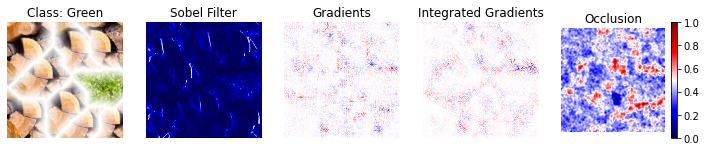

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


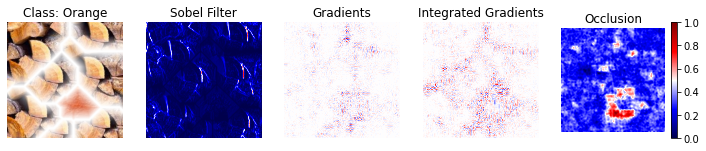

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


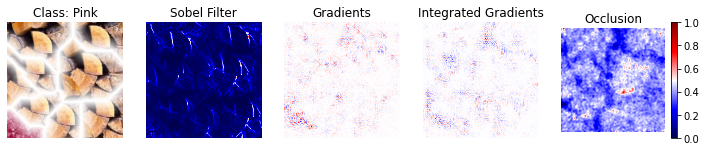

In [ ]:
for name in ["mobilenet_freezed"]: #['mlp112', 'mlp224']: #['resnet18_freezed', 'resnet18_unfreezed', 'mobilenet_freezed', 'mobilenet_unfreezed']:
    
    
    model = load_models(name=name)
    model.to(device)
    
    #y_pred, y_true = evaluate_model(model.to(device), test_images.to(device), test_labels.to(device), device)
    #test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
    #print(f"Model {name.upper()} - test accuracy: {(100 * test_acc):.2f}%")

    # Load a batch of inputs and outputs to use for evaluation.
    samples = 30
    x_batch, y_batch, s_batch = test_images[0:samples].to(device), test_labels[0:samples].to(device), test_masks[0:samples].to(device)

    # Generate attribution-based explanations of the first batch of the test set, including a control variant.
    a_batch_g = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=False).sum(axis=1).cpu().numpy()
    a_batch_in = InputXGradient(model).attribute(inputs=x_batch, target=y_batch).sum(axis=1).detach().cpu().numpy()
    a_batch_ig = IntegratedGradients(model).attribute(inputs=x_batch, 
                                                      target=y_batch, 
                                                      baselines=torch.zeros_like(x_batch), 
                                                      n_steps=10, 
                                                      method="riemann_trapezoid").sum(axis=1).cpu().numpy()
    a_batch_oc = Occlusion(model).attribute(inputs=x_batch, target=y_batch, sliding_window_shapes=(1, 4, 4)).sum(axis=1).cpu().numpy()
    a_batch_convar = np.array([np.abs(scipy.ndimage.sobel(x_batch[n].cpu().numpy())).mean(axis=0).reshape(224, 224) for n in range(samples)]) #np.clip(

    # Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
    x_batch, y_batch, s_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy(), s_batch.cpu().numpy()

    # Quick assert.
    assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, a_batch_g, a_batch_ig, a_batch_convar]]

    for index in [0, 20, 16]:

        # Plot examplary explanations!
        fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 6))

        # Plot!
        axes[0].imshow(np.moveaxis(quantus.denormalize_image(x_batch[index]), 0, -1), vmin=0.0, vmax=1.0)
        a1 = axes[1].imshow(quantus.normalize_heatmap(a_batch_convar[index]), cmap="seismic") 
        a2 = axes[2].imshow(quantus.normalize_heatmap(a_batch_g[index]), cmap="seismic") 
        a3 = axes[3].imshow(quantus.normalize_heatmap(a_batch_ig[index]), cmap="seismic") 
        a4 = axes[4].imshow(quantus.normalize_heatmap(a_batch_oc[index]), cmap="seismic")

        # Set titles.
        axes[0].title.set_text(f"Class: {class_labels[test_labels[index].item()]}")
        axes[1].title.set_text(f"Sobel Filter")
        axes[2].title.set_text(f"Gradients")
        axes[3].title.set_text(f"Integrated Gradients")
        axes[4].title.set_text(f"Occlusion")

        # Make colorbars.
        fig.colorbar(a1, fraction=0.05, pad=0.05, orientation="vertical")

        # Other configs.
        axes[0].axis("off") 
        axes[1].axis("off")
        axes[2].axis("off")
        axes[3].axis("off")
        axes[4].axis("off")
        
        plt.show()

In [ ]:
quantus.available_metrics()

{'Axiomatic': ['Completeness Test',
  'Symmetry',
  'InputInvariance',
  'NonSensitivity',
  'Dummy'],
 'Complexity': ['Sparseness Test', 'Complexity Test', 'Effective Complexity'],
 'Faithfulness': ['Faithfulness Correlation',
  'Faithfulness Estimate',
  'Pixel-Flipping',
  'Region Segmentation',
  'Monotonicity Arya',
  'Monotonicity Nguyen',
  'Infidelity',
  'Selectivity',
  'SensitivityN',
  'IROF'],
 'Localisation': ['Pointing Game',
  'TKI',
  'Relevance Mass Accuracy',
  'Relevance Mass Ranking',
  'Attribution Localization '],
 'Randomisation': ['Model Parameter Randomisation Test', 'Random Logit Test'],
 'Robustness': ['Continuity Test',
  'Input Independence Rate',
  'Local Lipschitz Estimate',
  'Max-Sensitivity',
  'Avg-Sensitivity']}

In [ ]:
# Pick a model!
name = "mobilenet_freezed"
model = load_models(name=name)
model.to(device)

y_pred, y_true = evaluate_model(model.to(device), test_images.to(device), test_labels.to(device), device)
test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())

print(f"Model {name.upper()} - test accuracy: {(100 * test_acc):.2f}%")

Model MOBILENET_FREEZED - test accuracy: 100.00%


In [ ]:
# Specify XAI methods, either as a list (str) or as a dictionary with names of explantion methods(str) and either their pre-computed attributions (np.ndarray) or a explanation_func (callable).
explanation_methods = {"Saliency": a_batch_g,
                       "IntegratedGradients": a_batch_ig,
                       "Occlusion": a_batch_oc,
                       "Control Var. Sobel Filter": a_batch_convar}

# Specify metrics and set (sensible) hyperparameters.
evaluation_metrics = {"TopK Intersection": quantus.TopKIntersection(**{"explain_func": quantus.explain, 
                                                                       "abs": False}),
                      "Pointing Game": quantus.PointingGame(),
                      "Relevance Rank Accuracy": quantus.RelevanceRankAccuracy(),
                      "Attribution Localization": quantus.AttributionLocalization(),
                      "Faithfulness correlation": quantus.FaithfulnessCorrelation(**{"subset_size": 224}),
                      "max-Sensitivity": quantus.MaxSensitivity(**{"nr_samples": 10,
                                                                   "perturb_radius": 0.2,
                                                                   "norm_numerator": quantus.fro_norm,
                                                                   "norm_denominator": quantus.fro_norm,
                                                                   "explain_func": quantus.explain,
                                                                   "perturb_func": quantus.uniform_sampling,
                                                                   "similarity_func": quantus.difference,
                                                                }),
                      #"Infidelity": quantus.Infidelity(**{"perturb_patch_sizes": list(np.arange(2, 8)),"img_size": 32, "nr_channels": 3})
                      }

 # Evaluate explanations!
results = quantus.evaluate(evaluation_metrics=evaluation_metrics, 
                           explanation_methods=explanation_methods,
                           model=model,
                           x_batch=x_batch,
                           y_batch=y_batch,
                           s_batch=s_batch,
                           agg_func=np.mean,
                           **{"device": device})

# Summarise in a dataframe.
df = pd.DataFrame(results).T
df

### Voronoy toy data - old results

In [ ]:
"""
https://github.com/understandable-machine-intelligence-lab/NoiseGrad/blob/master/examples/example-noisegrad-pytorch.ipynb

noisegrad = NoiseGrad(model=model, weights=weights, std=0.25, n=25)

# Get NoiseGrad explanation.
expl_ng = noisegrad.enhance_explanation(inputs=normalised_image, targets=label, explanation_fn=intgrad_explainer, **{"device": device})
""";

In [ ]:
for name in ['mlp28', 'mlp56', 'mlp112', 'mlp224', 'resnet18_freezed', 'resnet18_unfreezed', 'mobilenet_freezed', 'mobilenet_unfreezed', 'vgg16_unfreezed', 'vgg16_freezed']:
    
    model = load_models(name=name)
    model.to(device)
    
    y_pred, y_true = evaluate_model(model.to(device), test_images.to(device), test_labels.to(device), device)
    test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())

    print(f"Model {name.upper()} - test accuracy: {(100 * test_acc):.2f}%")
    
    # Load a batch of inputs and outputs to use for evaluation.
    samples = 10
    x_batch, y_batch, s_batch = test_images[0:samples].to(device), test_labels[0:samples].to(device), test_masks[0:samples].to(device)

    # Generate attribution-based explanations of the first batch of the test set, including a control variant.
    a_batch_g = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
    a_batch_ig = IntegratedGradients(model).attribute(inputs=x_batch, 
                                                      target=y_batch, 
                                                      baselines=torch.zeros_like(x_batch), 
                                                      n_steps=10, 
                                                      method="riemann_trapezoid").sum(axis=1).cpu().numpy()
    a_batch_convar = np.array([np.clip(scipy.ndimage.sobel(x_batch[n].cpu().numpy()), 0, 1).mean(axis=0).reshape(kwargs.get("img_size", 224), kwargs.get("img_size", 224)) for n in range(samples)])

    # Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
    x_batch, y_batch, s_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy(), s_batch.cpu().numpy()

    # Quick assert.
    assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, a_batch_g, a_batch_ig, a_batch_convar]]

    for index in [0, 1, 5]:

        # Plot examplary explanations!
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))

        # Plot!
        axes[0].imshow(np.moveaxis(x_batch[index], 0, -1), vmin=0.0, vmax=1.0)
        a2 = axes[1].imshow(quantus.normalize_heatmap(a_batch_convar[index]), cmap="seismic") 
        a1 = axes[2].imshow(quantus.normalize_heatmap(a_batch_g[index]), cmap="seismic") 
        a2 = axes[3].imshow(quantus.normalize_heatmap(a_batch_ig[index]), cmap="seismic") 

        # Set titles.
        axes[0].title.set_text(f"Class: {class_labels[test_labels[index].item()]}")
        axes[1].title.set_text(f"Sobel Filter")
        axes[2].title.set_text(f"Saliency")
        axes[3].title.set_text(f"Integrated Gradients")

        # Make colorbars.
        fig.colorbar(a1, fraction=0.05, pad=0.05, orientation="vertical")

        # Other configs.
        axes[0].axis("off") 
        axes[1].axis("off")
        axes[2].axis("off")
        axes[3].axis("off")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Specify XAI methods, either as a list (str) or as a dictionary with names of explantion methods(str) and either their pre-computed attributions (np.ndarray) or a explanation_func (callable).
explanation_methods = {"Saliency": a_batch_g,
                       "IntegratedGradients": a_batch_ig,
                       "Control Var. Sobel Filter": a_batch_convar}

# Specify metrics and set (sensible) hyperparameters.
evaluation_metrics = {"TopK Intersection": quantus.TopKIntersection(**{"explain_func": quantus.explain, 
                                                                       "abs": False}),
                      "Pointing Game": quantus.PointingGame(),
                      "Relevance Rank Accuracy": quantus.RelevanceRankAccuracy(),
                      "Attribution Localization": quantus.AttributionLocalization(),
                      "Faithfulness correlation": quantus.FaithfulnessCorrelation(**{"subset_size": 224}),
                      "max-Sensitivity": quantus.MaxSensitivity(**{"nr_samples": 10,
                                                                   "perturb_radius": 0.2,
                                                                   "norm_numerator": quantus.fro_norm,
                                                                   "norm_denominator": quantus.fro_norm,
                                                                   "explain_func": quantus.explain,
                                                                   "perturb_func": quantus.uniform_sampling,
                                                                   "similarity_func": quantus.difference,
                                                                }),
                      #"Infidelity": quantus.Infidelity(**{"perturb_patch_sizes": list(np.arange(2, 8)),"img_size": 32, "nr_channels": 3})
                      }

 # Evaluate explanations!
results = quantus.evaluate(evaluation_metrics=evaluation_metrics, 
                           explanation_methods=explanation_methods,
                           model=model,
                           x_batch=x_batch,
                           y_batch=y_batch,
                           s_batch=s_batch,
                           agg_func=np.mean,
                           **{"device": device})

# Summarise in a dataframe.
df = pd.DataFrame(results).T
df

Evaluating Saliency explanations on TopK Intersection metric...
Evaluating Saliency explanations on Pointing Game metric...
Evaluating Saliency explanations on Relevance Rank Accuracy metric...
Evaluating Saliency explanations on Attribution Localization metric...
Evaluating Saliency explanations on Faithfulness correlation metric...
Evaluating Saliency explanations on max-Sensitivity metric...
Evaluating IntegratedGradients explanations on TopK Intersection metric...
Evaluating IntegratedGradients explanations on Pointing Game metric...
Evaluating IntegratedGradients explanations on Relevance Rank Accuracy metric...
Evaluating IntegratedGradients explanations on Attribution Localization metric...
Evaluating IntegratedGradients explanations on Faithfulness correlation metric...
Evaluating IntegratedGradients explanations on max-Sensitivity metric...
Evaluating Control Var. Sobel Filter explanations on TopK Intersection metric...
Evaluating Control Var. Sobel Filter explanations on Poin

,TopK Intersection,Pointing Game,Relevance Rank Accuracy,Attribution Localization,Faithfulness correlation,max-Sensitivity
Saliency,0.5208,0.1,0.189974,0.194777,-0.175078,0.252150
IntegratedGradients,0.0930,0.0,0.174817,0.158314,-0.010501,0.196834
Control Var. Sobel Filter,0.4020,0.2,0.207201,0.181688,-0.000056,0.186665
